In [ ]:
#Weighfun
import numpy       as np

def Weigfun( Tlag): 
    # WEIGFUN Summary of this function goes here
    #   Detailed explanation goes here
    nmax=int(np.ceil(Tlag))
    if nmax==1: 
        Weigths=float(1)
    else:
        Weigths=np.zeros(nmax)

        th=Tlag/2
        nh=int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i]=(float(i+1)-0.5)/th	    
        i=nh

        Weigths[i]=(1+(float(i+1)-1)/th)*(th-int(np.floor(th)))/2+(1+(Tlag-float(i+1))/th)*(int(np.floor(th))+1-th)/2
        for i in range(nh+1, int(np.floor(Tlag))):
            Weigths[i]=(Tlag-float(i+1)+.5)/th

        if Tlag>int(np.floor(Tlag)):
            Weigths[int(np.floor(Tlag))]=(Tlag-int(np.floor(Tlag)))**2/(2*th)

        Weigths=Weigths/sum(Weigths)

    return(Weigths)


In [ ]:
#HBVmod
import numpy       as np
import matplotlib.pyplot as plt

def HBVMod( Par,forcing,Sin, hydrograph):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax=Par[0]
    Ce=Par[1]
    Sumax=Par[2]
    beta=Par[3]
    Pmax=Par[4]
    Tlag=Par[5]
    Kf=Par[6]
    Ks=Par[7]    
    
    Qo=forcing[:,0]
    Prec=forcing[:,1]
    Etp=forcing[:,2]
    
    tmax=len(Prec)
    Si=np.zeros(tmax)
    Su=np.zeros(tmax)
    Sf=np.zeros(tmax)
    Ss=np.zeros(tmax) 
    Eidt=np.zeros(tmax)
    Eadt=np.zeros(tmax)
    Qtotdt=np.zeros(tmax)
    
    Si[0]=Sin[0]
    Su[0]=Sin[1]
    Sf[0]=Sin[2]
    Ss[0]=Sin[3]
    
    dt=1

    # Model 1 SOF1
    for i in range(0,tmax):
        Pdt=Prec[i]*dt
        Epdt=Etp[i]*dt
        # Interception Reservoir
        if Pdt>0:
            Si[i]=Si[i]+Pdt
            Pedt=max(0,Si[i]-Imax)
            Si[i]=Si[i]-Pedt
            Eidt[i]=0
        else:
            # Evaporation only when there is no rainfall
            Pedt=0
            Eidt[i]=min(Epdt,Si[i])
            Si[i]=Si[i]-Eidt[i]
                
        if i<tmax-1:
            Si[i+1]=Si[i]       
                
            # Unsaturated Reservoir
        if Pedt>0:
            rho=(Su[i]/Sumax)**beta            
            Su[i]=Su[i]+(1-rho)*Pedt
            Qufdt=rho*Pedt
        else:
            Qufdt=0
                
            # Transpiration
        Epdt=max(0,Epdt-Eidt[i])
        Eadt[i]=Epdt*(Su[i]/(Sumax*Ce))
        Eadt[i]=min(Eadt[i],Su[i])
        Su[i]=Su[i]-Eadt[i]
            # Percolation
        Qusdt=(Su[i]/Sumax)*Pmax*dt
        Su[i]=Su[i]-min(Qusdt,Su[i])
        if i<tmax-1:
            Su[i+1]=Su[i]
                
            # Fast Reservoir
        Sf[i]=Sf[i]+Qufdt
        Qfdt= dt*Kf*Sf[i]
        Sf[i]=Sf[i]-min(Qfdt,Sf[i])
        if i<tmax-1:
            Sf[i+1]=Sf[i]
                
            # Slow Reservoir
        Ss[i]=Ss[i]+Qusdt
        Qsdt= dt*Ks*Ss[i]
        Ss[i]=Ss[i]-min(Qsdt,Ss[i])
        if i<tmax-1:
            Ss[i+1]=Ss[i]
            
        Qtotdt[i]=Qsdt+Qfdt
       
    # Check Water Balance
    Sf=Si[-1]+Ss[-1]+Sf[-1]+Su[-1]
    Sin=sum(Sin)
    WB=sum(Prec)-sum(Eidt)-sum(Eadt)-sum(Qtotdt)-Sf+Sin
    
    # Offset Q
    
    Weigths=Weigfun(Tlag)
    
    Qm = np.convolve(Qtotdt,Weigths)
    Qm=Qm[0:tmax]
    # Calculate objective
    ind=np.where(Qo>=0)
    QoAv=np.mean(Qo[ind])
    ErrUp=np.sum((Qo-Qm)**2)
    ErrDo=np.sum((Qo-QoAv)**2)
    Obj=1-(ErrUp/ErrDo)
    
    QoAvlog=np.mean(np.log(Qo[ind]))
    ErrUplog=np.sum((np.log(Qo)-np.log(Qm))**2)
    ErrDolog=np.sum((np.log(Qo)-QoAvlog)**2)
    Objlog=1-(ErrUplog/ErrDolog)
    
    if hydrograph == 'True':
        ## Plot
        # hour=1:tmax\
        plt.plot(range(0,len(Qo)),Qo,label='Qobs')
        plt.plot(range(0,len(Qm)),Qm,label='Qmod')
        plt.legend(loc='best')
        plt.show()
    
    return(Obj,Objlog)

In [ ]:
### A MC
import numpy       as np
import matplotlib as mpl
import pandas as pd

forcing=np.genfromtxt('data_WarkEttelbruck_adjusted_1.txt',  dtype=float, autostrip=True)

          #         Imax Ce    Sumax beta   Pmax   Tlag   Kf        Ks
ParMinn = np.array([0,   0.2,  40,    0.5,   0.001,   0,     0.1,  0.0001])
ParMaxn = np.array([10,    1,  400,   4,    0.3,     5,    0.5,   0.01])
Sin= np.array([0,  100,  0,  5  ])

forcing= forcing[:,3:6]


# GLUE
nmax=5000
A=np.zeros((nmax,9))
B=np.zeros((nmax,9))
n_feasible = 0
n_feasiblelog = 0

for n in range(1,nmax): 
    Rnum=np.random.random(8) #generate a vector of random number
    Par=Rnum*(ParMaxn-ParMinn)+ParMinn # calculate the random parameter set
    Obj=HBVMod(Par,forcing,Sin,hydrograph='FALSE')[0] #call the model

    if Obj>.6:
        A[n_feasible,0:8]= Par
        A[n_feasible,8]=Obj
        n_feasible = n_feasible + 1
        
for n in range(1,nmax): 
    Rnum=np.random.random(8) #generate a vector of random number
    Par=Rnum*(ParMaxn-ParMinn)+ParMinn # calculate the random parameter set
    Obj=HBVMod(Par,forcing,Sin,hydrograph='FALSE')[1] #call the model

    if Obj>.6:
        B[n_feasiblelog,0:8]= Par
        B[n_feasiblelog,8]=Obj
        n_feasiblelog = n_feasiblelog + 1


np.savetxt('MC2.txt',A[0:n_feasible,:], delimiter =',')
np.savetxt('MC3.txt',B[0:n_feasiblelog,:], delimiter =',')

The maximum N for Q is 0.7768280109917713
The maximum N for log(Q) is 0.8559971085279273


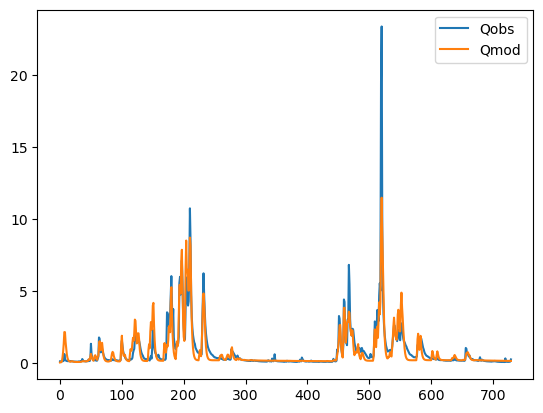

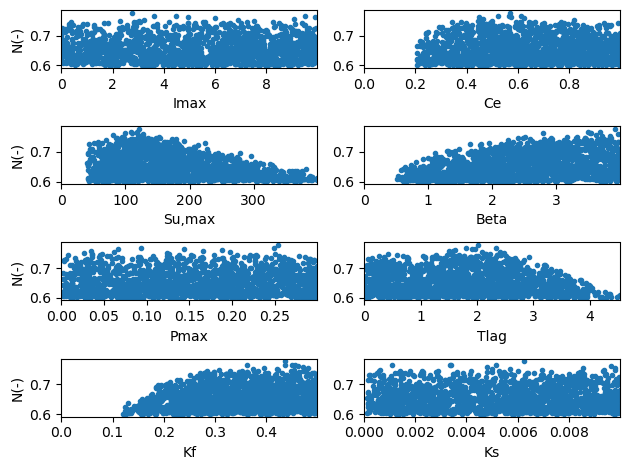

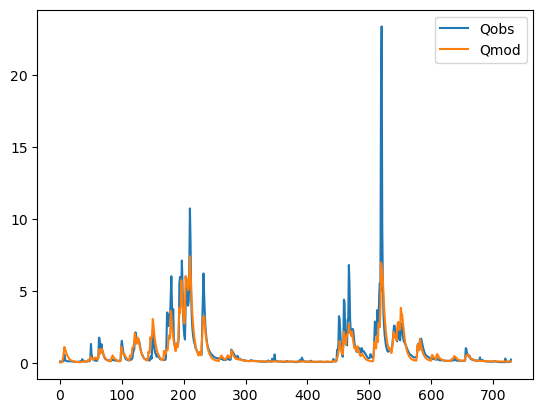

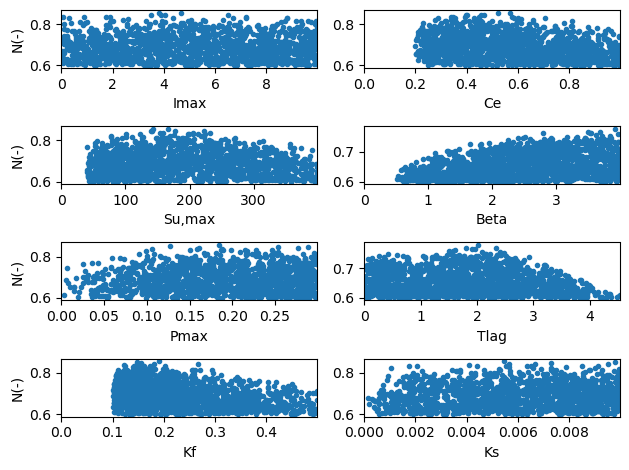

In [ ]:
## Bplot
import numpy       as np
import matplotlib.pyplot as plt
import pandas as pd

forcing=np.genfromtxt('data_WarkEttelbruck_adjusted_1.txt',  dtype=float, autostrip=True)

Sin= np.array([0,  100,  0,  5  ])

forcing= forcing[:,3:6]

x=pd.read_csv('MC2.txt',delimiter=',',header=None)
optimum=x[8].idxmax()
OptPar=np.array(x.loc[optimum,0:7])
print(f'The maximum N for Q is {max(x[8])}')

y=pd.read_csv('MC3.txt',delimiter=',',header=None)
optimumlog=y[8].idxmax()
OptParlog=np.array(y.loc[optimumlog,0:7])
print(f'The maximum N for log(Q) is {max(y[8])}')

plt.figure(1)
Obj=HBVMod(OptPar,forcing,Sin,hydrograph='True')

plt.figure(2)
plt.subplot(421)
plt.plot(x[0],x[8],'.')
plt.xlabel('Imax')
plt.ylabel('N(-)')
plt.xlim(0,max(x[0]))

plt.subplot(422)
plt.plot(x[1],x[8],'.')
plt.xlabel('Ce')
plt.xlim(0,max(x[1]))

plt.subplot(423)
plt.plot(x[2],x[8],'.')
plt.xlabel('Su,max')
plt.ylabel('N(-)')
plt.xlim(0,max(x[2]))

plt.subplot(424)
plt.plot(x[3],x[8],'.')
plt.xlabel('Beta')
plt.xlim(0,max(x[3]))

plt.subplot(425)
plt.plot(x[4],x[8],'.')
plt.xlabel('Pmax')
plt.ylabel('N(-)')
plt.xlim(0,max(x[4]))

plt.subplot(426)
plt.plot(x[5],x[8],'.')
plt.xlabel('Tlag')
plt.xlim(0,max(x[5]))

plt.subplot(427)
plt.plot(x[6],x[8],'.')
plt.xlabel('Kf')
plt.ylabel('N(-)')
plt.xlim(0,max(x[6]))

plt.subplot(428)
plt.plot(x[7],x[8],'.')
plt.xlabel('Ks')
plt.xlim(0,max(x[7]))

plt.tight_layout()

plt.figure(3)
Obj=HBVMod(OptParlog,forcing,Sin,hydrograph='True')

plt.figure(4)
plt.subplot(421)
plt.plot(y[0],y[8],'.')
plt.xlabel('Imax')
plt.ylabel('N(-)')
plt.xlim(0,max(y[0]))

plt.subplot(422)
plt.plot(y[1],y[8],'.')
plt.xlabel('Ce')
plt.xlim(0,max(y[1]))

plt.subplot(423)
plt.plot(y[2],y[8],'.')
plt.xlabel('Su,max')
plt.ylabel('N(-)')
plt.xlim(0,max(y[2]))

plt.subplot(424)
plt.plot(x[3],x[8],'.')
plt.xlabel('Beta')
plt.xlim(0,max(x[3]))

plt.subplot(425)
plt.plot(y[4],y[8],'.')
plt.xlabel('Pmax')
plt.ylabel('N(-)')
plt.xlim(0,max(y[4]))

plt.subplot(426)
plt.plot(x[5],x[8],'.')
plt.xlabel('Tlag')
plt.xlim(0,max(x[5]))

plt.subplot(427)
plt.plot(y[6],y[8],'.')
plt.xlabel('Kf')
plt.ylabel('N(-)')
plt.xlim(0,max(y[6]))

plt.subplot(428)
plt.plot(y[7],y[8],'.')
plt.xlabel('Ks')
plt.xlim(0,max(y[7]))

plt.tight_layout()
plt.show()